In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!pip install pymatreader
!pip install python-picard
!pip install hfda

import mne
import pymatreader
import scipy
import numpy as np
import scipy.io as sio
import os
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

import sklearn.multioutput as MOR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import welch
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from mne.decoding import Vectorizer
from mne.decoding import Scaler, PSDEstimator, FilterEstimator
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import hfda

from scipy.signal import welch
import scipy.stats as stats
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the DEAP dataset
X_data=np.zeros([32,40,32,8064])
X_new=np.zeros([32,40,32,8064])
y_data=np.zeros([32,40,3])
for i in range(32):
  if i<9:
    sub_data_file = sio.loadmat('/content/drive/My Drive/Dissertation/DEAP/data_preprocessed_matlab/s'+'0'+str(i+1)+'.mat')
  else:
    sub_data_file = sio.loadmat('/content/drive/My Drive/Dissertation/DEAP/data_preprocessed_matlab/s'+str(i+1)+'.mat')
  X = sub_data_file['data']
  X_data[i]=X[:,:32,:]
  y = sub_data_file['labels']
  y_data[i]=y[:,:3]
  
X_data.shape

(32, 40, 32, 8064)

In [ ]:
#raw signal for first trial
channels=['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4',
          'T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']
sigs=['ecg', 'bio', 'stim', 'eog', 'misc', 'seeg', 'dbs', 'ecog', 'mag','eeg','ref_meg', 'grad', 'emg', 'hbr','hbo']

info=mne.create_info(ch_names=channels,sfreq=128,ch_types='eeg')

for participant in range(X_data.shape[0]):
  for epoch in range(X_data.shape[1]):
    raw=mne.io.RawArray(X_data[participant][epoch],info)
    eeg_channels = mne.pick_types(raw.info, eeg=True,emg=True,ecg=True)
    cov=mne.compute_raw_covariance(raw, picks=eeg_channels)

    raw.del_proj()

    # BANDPASS FILTER
    filt_raw = raw.copy().filter(l_freq=4, h_freq=45,picks=eeg_channels)

    # ICA
    ica = ICA(n_components=32,noise_cov=cov,method='fastica',max_iter='auto',random_state=97)
    ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
    ica.exclude = []
    reconst_raw = filt_raw.copy()
    ica.apply(reconst_raw)

    # X_NEW
    X_new[participant][epoch]=reconst_raw.get_data()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# DATA NORMALIZATION
for participant in range(X_new.shape[0]):
  mu=np.mean(X_new[participant],axis=0)
  std=np.std(X_new[participant],axis=0,ddof=1)
  for epoch in range(X_new.shape[1]):
    X_new[participant][epoch]=(X_new[participant][epoch]-mu)/std

In [ ]:
# DATA NORMALIZATION
X_new=np.zeros([32,40,32,8064])
for participant in range(X_new.shape[0]):
  mu=np.mean(X_data[participant],axis=0)
  std=np.std(X_data[participant],axis=0,ddof=1)
  for epoch in range(X_new.shape[1]):
    X_new[participant][epoch]=(X_data[participant][epoch]-mu)/std

In [ ]:
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
vec=Vectorizer()
X_new_=np.zeros([32,40,4128])
psd_svr=np.zeros([32,40,32,129])

rmse_svm=[]
mae_svm=[]
for participant in range(X_new.shape[0]):
  psd_svr[participant]=welch(X_new[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_[participant]=vec.fit_transform(psd_svr[participant])

  # REGRESSION 
  # With SVR
  svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
  clf=MOR.MultiOutputRegressor(svr)
  y_pred=cross_val_predict(clf,X_new_[participant],y_data[participant],cv=5)


  # METRICS FOR SVR
  MSE=mean_squared_error(y_data[participant],y_pred)
  MAE=mean_absolute_error(y_data[participant],y_pred)
  R2=r2_score(y_data[participant],y_pred)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE)))
  print('MAE for participant {} = {}'.format(participant,MAE))
  print('R2 for participant {} = {}'.format(participant,R2))
  print('')
  rmse_svm.append(MSE)
  mae_svm.append(MAE)

RMSE for participant 0 = 2.8125887388133406
MAE for participant 0 = 2.348423674728773
R2 for participant 0 = -0.503820245129172

RMSE for participant 1 = 3.2534742486328274
MAE for participant 1 = 2.8023355363078846
R2 for participant 1 = -0.2753245397039162

RMSE for participant 2 = 1.6069437406139784
MAE for participant 2 = 1.361382092167042
R2 for participant 2 = -0.40689947364827184

RMSE for participant 3 = 2.3776548350427382
MAE for participant 3 = 2.040767647469765
R2 for participant 3 = -0.3530173476597538

RMSE for participant 4 = 2.451550682552658
MAE for participant 4 = 1.9994665611655897
R2 for participant 4 = -0.21206971352821688

RMSE for participant 5 = 1.8251216484915451
MAE for participant 5 = 1.5440365528928541
R2 for participant 5 = -0.33591324475232204

RMSE for participant 6 = 2.34723547156154
MAE for participant 6 = 1.9602887654665704
R2 for participant 6 = -0.3289695049988235

RMSE for participant 7 = 1.8795214034719814
MAE for participant 7 = 1.4746762462035334


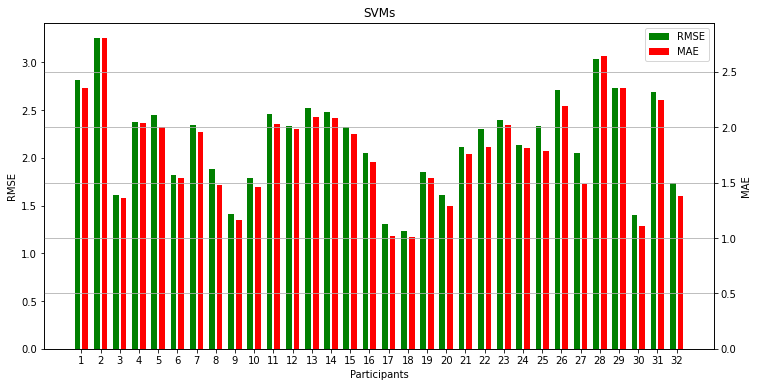

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_svm),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_svm,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('SVMs')
plt.grid(True)
plt.show()

In [ ]:
# SPLITTING OF DATA
X_new_knn=np.zeros([32,40,4128])
psd_knn=np.zeros([32,40,32,129])
rmse_knn=[]
mae_knn=[]
for participant in range(X_new.shape[0]):
  psd_knn[participant]=welch(X_new[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_knn[participant]=vec.fit_transform(psd_knn[participant])
  X_train, X_test, y_train, y_test = train_test_split(X_new_knn[participant], y_data[participant], test_size=0.2, random_state=42)

  # REGRESSION 
  # With k-NNS
  knn=KNeighborsRegressor(n_neighbors=16)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,X_new_knn[participant],y_data[participant],cv=5)

  # METRICS FOR k-NN
  MSE_knn=mean_squared_error(y_data[participant],y_pred_knn)
  MAE_knn=mean_absolute_error(y_data[participant],y_pred_knn)
  R2_knn=r2_score(y_data[participant],y_pred_knn)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_knn)))
  print('MAE for participant {} = {}'.format(participant,MAE_knn))
  print('R2 for participant {} = {}'.format(participant,R2_knn))
  print('')
  rmse_knn.append(MSE_knn)
  mae_knn.append(MAE_knn)

RMSE for participant 0 = 2.437653909403722
MAE for participant 0 = 2.242677083333333
R2 for participant 0 = -0.17699624043244813

RMSE for participant 1 = 3.0891316681052343
MAE for participant 1 = 2.6620156250000004
R2 for participant 1 = -0.14652387558707022

RMSE for participant 2 = 1.4860739192110783
MAE for participant 2 = 1.2517864583333334
R2 for participant 2 = -0.19747044434343

RMSE for participant 3 = 2.2452006539644738
MAE for participant 3 = 1.9254583333333335
R2 for participant 3 = -0.22587144314373261

RMSE for participant 4 = 2.3484454562961252
MAE for participant 4 = 1.9585625000000002
R2 for participant 4 = -0.11864845181037371

RMSE for participant 5 = 1.7258062927298767
MAE for participant 5 = 1.501536458333333
R2 for participant 5 = -0.20843199431815349

RMSE for participant 6 = 2.2088530154539954
MAE for participant 6 = 1.9136822916666667
R2 for participant 6 = -0.17478004810539902

RMSE for participant 7 = 1.8750029852406793
MAE for participant 7 = 1.506359375000

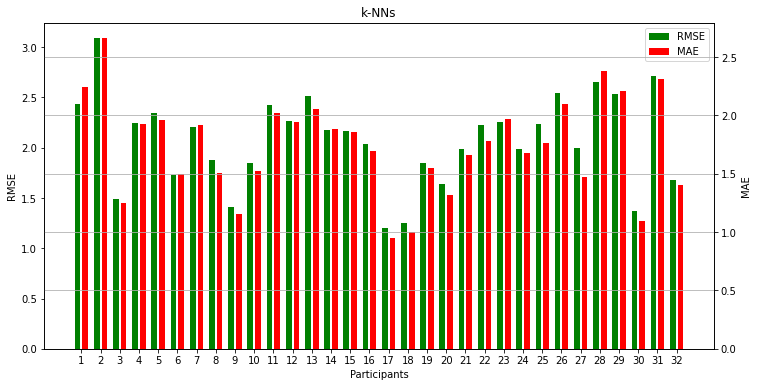

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_knn),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_knn,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('k-NNs')
plt.grid(True)
plt.show()

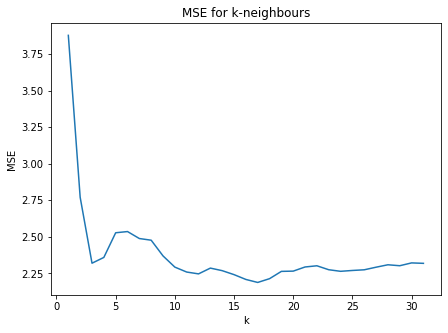


Number of k with lowest MSE equal to 16 and with MSE equal to 2.1879244463667824


In [ ]:
# HYPER-PARAMETER TUNING FOR K-NNS
dec=X_new[2]
psd_knn=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_knn=vec.fit_transform(psd_knn)

mse=[]
for k in range(1,32):
  knn=KNeighborsRegressor(n_neighbors=k)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_knn,y_data[2],cv=5)
  MSE_knn=mean_squared_error(y_data[2],y_pred_knn)
  mse.append(MSE_knn)

k=np.where(mse==np.min(mse))


import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(range(1,32),mse)
plt.title('MSE for k-neighbours')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of k with lowest MSE equal to {} and with MSE equal to {}'.format(k[0][0],np.min(mse)))

In [ ]:
# SPLITTING OF DATA
X_new_rf=np.zeros([32,40,4128])
psd_rf=np.zeros([32,40,32,129])

rmse_rf=[]
mae_rf=[]
for participant in range(X_new.shape[0]):
  psd_rf[participant]=welch(X_new[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_rf[participant]=vec.fit_transform(psd_rf[participant])

  # REGRESSION
  # With RFs
  rf=RandomForestRegressor(n_estimators=51, criterion='absolute_error', max_depth=8)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,X_new_rf[participant],y_data[participant],cv=5)

  # METRICS FOR RF
  MSE_rf=mean_squared_error(y_data[participant],y_pred_rf)
  MAE_rf=mean_absolute_error(y_data[participant],y_pred_rf)
  R2_rf=r2_score(y_data[participant],y_pred_rf)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_rf)))
  print('MAE for participant {} = {}'.format(participant,MAE_rf))
  print('R2 for participant {} = {}'.format(participant,R2_rf))
  print('')
  rmse_rf.append(MSE_rf)
  mae_rf.append(MAE_rf)

RMSE for participant 0 = 2.701540830940607
MAE for participant 0 = 2.4551568627450977
R2 for participant 0 = -0.4403740818592515

RMSE for participant 1 = 3.0648441171691676
MAE for participant 1 = 2.6240277777777776
R2 for participant 1 = -0.12772568098542525

RMSE for participant 2 = 1.42456241316831
MAE for participant 2 = 1.145277777777778
R2 for participant 2 = -0.12171229325053208

RMSE for participant 3 = 1.948006843562332
MAE for participant 3 = 1.6698186274509805
R2 for participant 3 = 0.0672522870973054

RMSE for participant 4 = 2.381059801900985
MAE for participant 4 = 1.9227818627450979
R2 for participant 4 = -0.17445459966719926

RMSE for participant 5 = 1.7646225169806036
MAE for participant 5 = 1.5034861111111109
R2 for participant 5 = -0.23434086586167635

RMSE for participant 6 = 2.208993094139451
MAE for participant 6 = 1.8913848039215686
R2 for participant 6 = -0.18432174399197443

RMSE for participant 7 = 1.9872007082557992
MAE for participant 7 = 1.5905629084967323

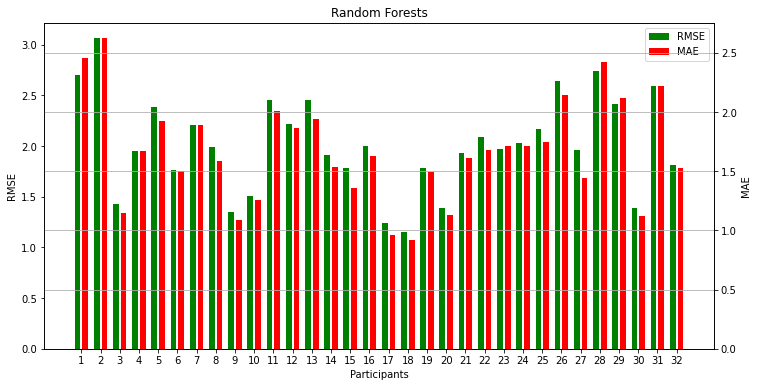

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_rf),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_rf,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('Random Forests')
plt.grid(True)
plt.show()

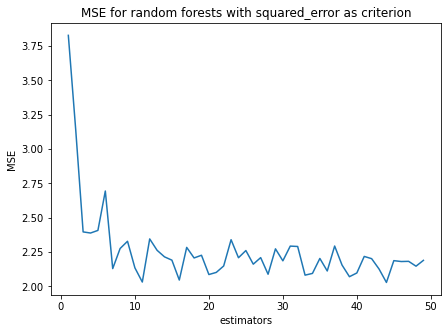


Number of estimators with lowest MSE equal to 43 and with MSE equal to 2.0282527724690085


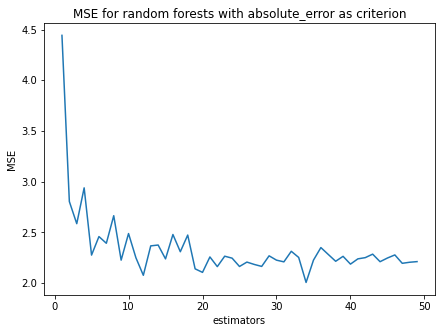


Number of estimators with lowest MSE equal to 33 and with MSE equal to 2.0070074156574402


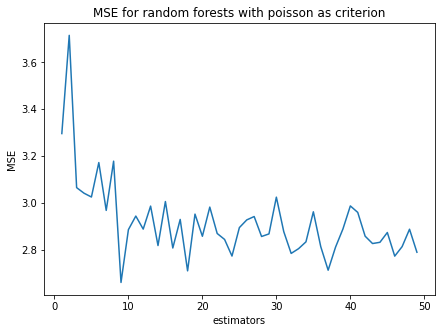


Number of estimators with lowest MSE equal to 8 and with MSE equal to 2.659633261316872


In [ ]:
# HYPER-PARAMETER TUNING FOR RANDOM FORESTS
dec=X_new[2]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)

criteria=['squared_error','absolute_error', 'poisson']

for criterion in criteria:
  mse=[]
  for estimator in range(1,50):
    rf=RandomForestRegressor(n_estimators=estimator, criterion=criterion, max_depth=None)
    regr_rf=MOR.MultiOutputRegressor(rf)
    y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
    MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
    mse.append(MSE_rf)

  _k=np.where(mse==np.min(mse))

  plt.figure(figsize=(7,5))
  plt.plot(range(1,50),mse)
  plt.title('MSE for random forests with {} as criterion'.format(criterion))
  plt.xlabel('estimators')
  plt.ylabel('MSE')
  plt.show()
  print('')
  print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

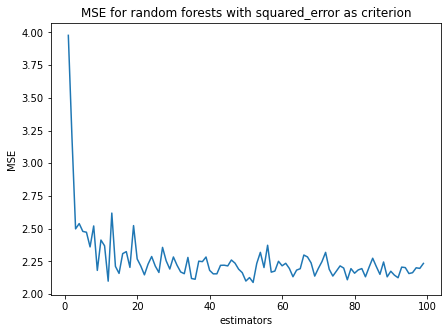


Number of estimators with lowest MSE equal to 51 and with MSE equal to 2.0888491903969433


In [ ]:
# TUNING FOR NUMBER OF ESTIMATORS
dec=X_new[2]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)
X_train, X_test, y_train, y_test = train_test_split(psd_rf, y_data[2], test_size=0.2, random_state=42)

mse=[]
for estimator in range(1,100):
  rf=RandomForestRegressor(n_estimators=estimator, criterion='absolute_error', max_depth=None)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
  MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,100),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

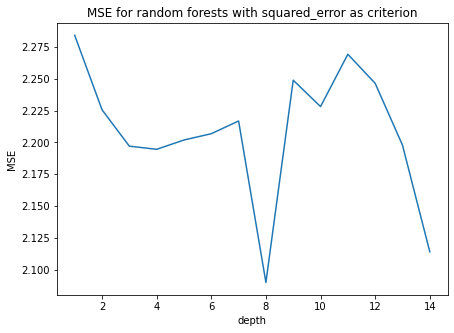


Maximum depth with lowest MSE equal to 7 and with MSE equal to 2.0898746608676158


In [ ]:
# TUNING FOR MAX-DEPTH
dec=X_new[2]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)

mse=[]
for depth in range(1,15):
  rf=RandomForestRegressor(n_estimators=51, criterion='absolute_error', max_depth=depth)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
  MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,15),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('depth')
plt.ylabel('MSE')
plt.show()
print('')
print('Maximum depth with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))